# Flux Microscopy Image Enhancement Demo

This notebook uses the Flux Kontext model to intelligently enhance cellular microscopy images, improving image clarity and contrast.

In [1]:
# Import necessary libraries
import torch
from diffusers import FluxKontextPipeline
from diffusers.utils import load_image
import matplotlib.pyplot as plt
import os
import re
import random
import glob

# Load Flux Kontext model
print("Loading Flux Kontext model...")
pipe = FluxKontextPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-Kontext-dev", torch_dtype=torch.bfloat16
)
pipe.to("cuda")
print("✅ Model loaded successfully")

Loading Flux Kontext model...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Model loaded successfully


In [2]:
# Image selection and parameter configuration

def get_random_images(base_path, num_images):
    """Randomly select images from specified directory"""
    image_extensions = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.tiff", "*.tif"]
    all_images = []

    for ext in image_extensions:
        all_images.extend(glob.glob(os.path.join(base_path, ext)))

    if len(all_images) < num_images:
        print(f"Warning: Only {len(all_images)} images found in {base_path}, less than requested {num_images} images")
        return all_images

    return random.sample(all_images, num_images)


def is_brightfield_folder(folder_name):
    """Check if folder contains bright-field images (A folders)"""
    pattern = r"(train|test)A(_|\d|$)"
    return bool(re.search(pattern, folder_name, re.IGNORECASE))


def is_stained_folder(folder_name):
    """Check if folder contains stained images (B folders)"""
    pattern = r"(train|test)B(_|\d|$)"
    return bool(re.search(pattern, folder_name, re.IGNORECASE))


# Define specialized prompts for different image types
# For bright-field microscopy images (A folders) - enhanced for better edge clarity
brightfield_prompt = "enhance bright-field microscopy, high cell-background contrast, sharp crisp cell boundaries, clear defined edges, enhanced cell outline"
brightfield_negative = "noise amplification, grain, speckle, background texture, blurry edges, soft boundaries"

# For stained cell images (B folders) - gentle enhancement with preserved cellular structures  
stained_prompt = "enhance stained microscopy, preserve cellular structures, improve clarity, maintain natural staining patterns, enhance cell visibility"
stained_negative = "distortion, color shift, over-enhancement, artificial appearance, noise amplification, artifacts, excessive contrast, unnatural colors"

# Set paths and parameters
base_dir = "../cell_datasets/confocal_new"
trainA_path = os.path.join(base_dir, "trainA")
trainB_path = os.path.join(base_dir, "trainB")
num_images = 5

# Check directories and select images
if not os.path.exists(trainA_path):
    raise FileNotFoundError(f"Directory does not exist: {trainA_path}")
if not os.path.exists(trainB_path):
    raise FileNotFoundError(f"Directory does not exist: {trainB_path}")

trainA_images = get_random_images(trainA_path, num_images)
trainB_images = get_random_images(trainB_path, num_images)
image_paths = trainA_images + trainB_images

print("Selected images:")
for path in image_paths:
    subfolder = os.path.basename(os.path.dirname(path))
    filename = os.path.basename(path)
    image_type = "Bright-field" if is_brightfield_folder(subfolder) else "Stained" if is_stained_folder(subfolder) else "Unknown"
    print(f"  {subfolder}/{filename} ({image_type})")

print(f"\n✅ Configuration completed, will process {len(image_paths)} images with optimized enhancement")

Selected images:
  trainA/124.jpg (Bright-field)
  trainA/218.jpg (Bright-field)
  trainA/173.jpg (Bright-field)
  trainA/459.jpg (Bright-field)
  trainA/383.jpg (Bright-field)
  trainB/75.jpg (Stained)
  trainB/1101.jpg (Stained)
  trainB/996.jpg (Stained)
  trainB/1106.jpg (Stained)
  trainB/191.jpg (Stained)

✅ Configuration completed, will process 10 images with optimized enhancement


In [3]:
# Batch image enhancement processing with optimized parameters

results = []

print("Starting image enhancement processing...")
for i, img_path in enumerate(image_paths, 1):
    input_image = load_image(img_path)
    
    # Determine image type based on folder name
    subfolder = os.path.basename(os.path.dirname(img_path))
    filename = os.path.basename(img_path)
    
    # Select appropriate prompts and parameters based on folder type
    if is_brightfield_folder(subfolder):  # A folders - Bright-field images
        current_prompt = brightfield_prompt
        current_negative = brightfield_negative
        guidance_scale = 4.0  # Increased for better edge enhancement
        num_steps = 55  # Slightly more steps for better edge definition
        image_type = "Bright-field"
    elif is_stained_folder(subfolder):  # B folders - Stained images
        current_prompt = stained_prompt
        current_negative = stained_negative
        guidance_scale = 3.0  # Reduced to prevent distortion
        num_steps = 45  # Fewer steps for gentler processing
        image_type = "Stained"
    else:
        # Default fallback for unknown folder types
        current_prompt = "enhance microscopy image, improve clarity, noise reduction"
        current_negative = "noise amplification, artifacts, over-processing"
        guidance_scale = 3.5
        num_steps = 50
        image_type = "Unknown"
    
    # Use Flux for image enhancement with optimized prompts and parameters
    enhanced_image = pipe(
        image=input_image,
        prompt=current_prompt,
        negative_prompt=current_negative,
        guidance_scale=guidance_scale,
        num_inference_steps=num_steps,
    ).images[0]
    
    # Save results
    label = f"{subfolder}/{filename}"
    
    results.append((input_image, enhanced_image, label, image_type))
    print(f"✅ [{i}/{len(image_paths)}] {image_type} enhancement completed: {label}")
    print(f"    Parameters: guidance_scale={guidance_scale}, steps={num_steps}")

print(f"\n🎉 All image enhancement completed! Processed {len(results)} images in total")

Starting image enhancement processing...


  0%|          | 0/55 [00:00<?, ?it/s]

✅ [1/10] Bright-field enhancement completed: trainA/124.jpg
    Parameters: guidance_scale=4.0, steps=55


  0%|          | 0/55 [00:00<?, ?it/s]

✅ [2/10] Bright-field enhancement completed: trainA/218.jpg
    Parameters: guidance_scale=4.0, steps=55


  0%|          | 0/55 [00:00<?, ?it/s]

✅ [3/10] Bright-field enhancement completed: trainA/173.jpg
    Parameters: guidance_scale=4.0, steps=55


  0%|          | 0/55 [00:00<?, ?it/s]

✅ [4/10] Bright-field enhancement completed: trainA/459.jpg
    Parameters: guidance_scale=4.0, steps=55


  0%|          | 0/55 [00:00<?, ?it/s]

✅ [5/10] Bright-field enhancement completed: trainA/383.jpg
    Parameters: guidance_scale=4.0, steps=55


  0%|          | 0/45 [00:00<?, ?it/s]

✅ [6/10] Stained enhancement completed: trainB/75.jpg
    Parameters: guidance_scale=3.0, steps=45


  0%|          | 0/45 [00:00<?, ?it/s]

✅ [7/10] Stained enhancement completed: trainB/1101.jpg
    Parameters: guidance_scale=3.0, steps=45


  0%|          | 0/45 [00:00<?, ?it/s]

✅ [8/10] Stained enhancement completed: trainB/996.jpg
    Parameters: guidance_scale=3.0, steps=45


  0%|          | 0/45 [00:00<?, ?it/s]

✅ [9/10] Stained enhancement completed: trainB/1106.jpg
    Parameters: guidance_scale=3.0, steps=45


  0%|          | 0/45 [00:00<?, ?it/s]

✅ [10/10] Stained enhancement completed: trainB/191.jpg
    Parameters: guidance_scale=3.0, steps=45

🎉 All image enhancement completed! Processed 10 images in total


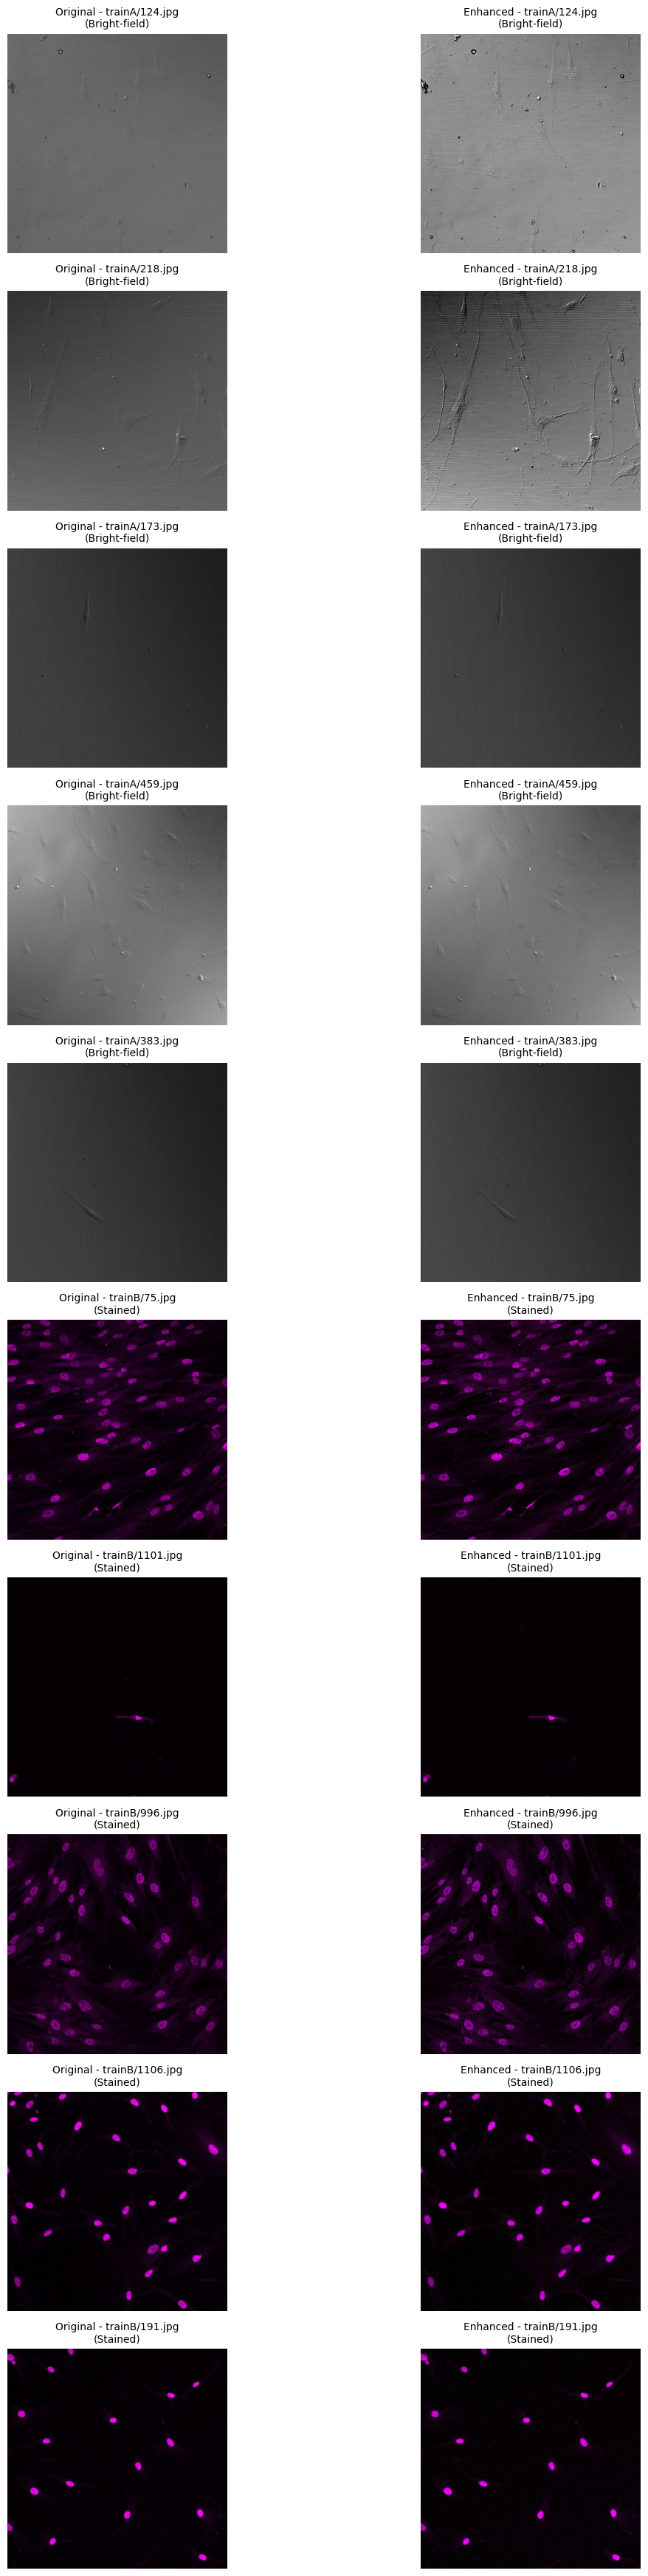

📊 Display completed, compared 10 image pairs
📈 Processing summary: 5 bright-field images, 5 stained images


In [4]:
# Compare and display enhancement results

if not results:
    print("⚠️ No processing results found, please run the image enhancement cell above first")
else:
    rows = len(results)
    plt.figure(figsize=(14, 3.5 * rows))
    
    for i, (orig, enhanced, label, image_type) in enumerate(results):
        # Original image
        plt.subplot(rows, 2, 2 * i + 1)
        plt.title(f"Original - {label}\n({image_type})", fontsize=10)
        plt.imshow(orig)
        plt.axis("off")
        
        # Enhanced image
        plt.subplot(rows, 2, 2 * i + 2)
        plt.title(f"Enhanced - {label}\n({image_type})", fontsize=10)
        plt.imshow(enhanced)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    print(f"📊 Display completed, compared {len(results)} image pairs")
    
    # Summary of processing
    brightfield_count = sum(1 for _, _, _, img_type in results if img_type == "Bright-field")
    stained_count = sum(1 for _, _, _, img_type in results if img_type == "Stained")
    print(f"📈 Processing summary: {brightfield_count} bright-field images, {stained_count} stained images")

In [5]:
# Image quality evaluation: PSNR and SSIM calculation

import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.util import img_as_float

def calculate_psnr_ssim(original, enhanced):
    """Calculate PSNR and SSIM between original and enhanced images"""
    # Convert images to float arrays
    orig_float = img_as_float(np.array(original))
    enhanced_float = img_as_float(np.array(enhanced))
    
    # Ensure both images have the same shape
    if orig_float.shape != enhanced_float.shape:
        min_h = min(orig_float.shape[0], enhanced_float.shape[0])
        min_w = min(orig_float.shape[1], enhanced_float.shape[1])
        orig_float = orig_float[:min_h, :min_w]
        enhanced_float = enhanced_float[:min_h, :min_w]
    
    # Calculate PSNR
    psnr = peak_signal_noise_ratio(orig_float, enhanced_float, data_range=1.0)
    
    # Calculate SSIM
    if len(orig_float.shape) == 3:  # Color image
        ssim = structural_similarity(orig_float, enhanced_float, 
                                   data_range=1.0, 
                                   channel_axis=-1)
    else:  # Grayscale image
        ssim = structural_similarity(orig_float, enhanced_float, 
                                   data_range=1.0)
    
    return psnr, ssim

if not results:
    print("⚠️ No processing results found, please run the image enhancement cell above first")
else:
    print("📊 Image Quality Evaluation (PSNR & SSIM)")
    print("=" * 80)
    print(f"{'Image':<35} {'Type':<12} {'PSNR (dB)':<12} {'SSIM':<10}")
    print("-" * 80)
    
    total_psnr = 0
    total_ssim = 0
    brightfield_psnr = []
    brightfield_ssim = []
    stained_psnr = []
    stained_ssim = []
    
    for i, (orig, enhanced, label, image_type) in enumerate(results):
        psnr, ssim = calculate_psnr_ssim(orig, enhanced)
        
        print(f"{label:<35} {image_type:<12} {psnr:<12.2f} {ssim:<10.4f}")
        
        total_psnr += psnr
        total_ssim += ssim
        
        # Collect metrics by image type
        if image_type == "Bright-field":
            brightfield_psnr.append(psnr)
            brightfield_ssim.append(ssim)
        elif image_type == "Stained":
            stained_psnr.append(psnr)
            stained_ssim.append(ssim)
    
    print("-" * 80)
    
    # Overall statistics
    avg_psnr = total_psnr / len(results)
    avg_ssim = total_ssim / len(results)
    print(f"{'Overall Average':<35} {'All':<12} {avg_psnr:<12.2f} {avg_ssim:<10.4f}")
    
    # Statistics by image type
    if brightfield_psnr:
        bf_avg_psnr = np.mean(brightfield_psnr)
        bf_avg_ssim = np.mean(brightfield_ssim)
        print(f"{'Bright-field Average':<35} {'Bright-field':<12} {bf_avg_psnr:<12.2f} {bf_avg_ssim:<10.4f}")
    
    if stained_psnr:
        st_avg_psnr = np.mean(stained_psnr)
        st_avg_ssim = np.mean(stained_ssim)
        print(f"{'Stained Average':<35} {'Stained':<12} {st_avg_psnr:<12.2f} {st_avg_ssim:<10.4f}")
    
    print("\n📈 Quality Metrics Explanation:")
    print("• PSNR (Peak Signal-to-Noise Ratio): Higher values indicate better quality")
    print("  - Typical range: 20-40 dB (higher is better)")
    print("  - >30 dB: Generally considered good quality")
    print("• SSIM (Structural Similarity Index): Range 0-1, closer to 1 indicates better similarity")
    print("  - >0.9: Excellent similarity")
    print("  - 0.8-0.9: Good similarity")
    print("  - <0.8: May indicate significant changes")
    
    print(f"\n✅ Quality evaluation completed for {len(results)} image pairs")

📊 Image Quality Evaluation (PSNR & SSIM)
Image                               Type         PSNR (dB)    SSIM      
--------------------------------------------------------------------------------
trainA/124.jpg                      Bright-field 16.50        0.5864    
trainA/218.jpg                      Bright-field 20.92        0.4607    
trainA/173.jpg                      Bright-field 29.81        0.8567    
trainA/459.jpg                      Bright-field 25.64        0.8654    
trainA/383.jpg                      Bright-field 30.17        0.9000    
trainB/75.jpg                       Stained      17.30        0.5312    
trainB/1101.jpg                     Stained      31.13        0.9279    
trainB/996.jpg                      Stained      18.78        0.5859    
trainB/1106.jpg                     Stained      17.12        0.7066    
trainB/191.jpg                      Stained      19.75        0.8042    
---------------------------------------------------------------------------

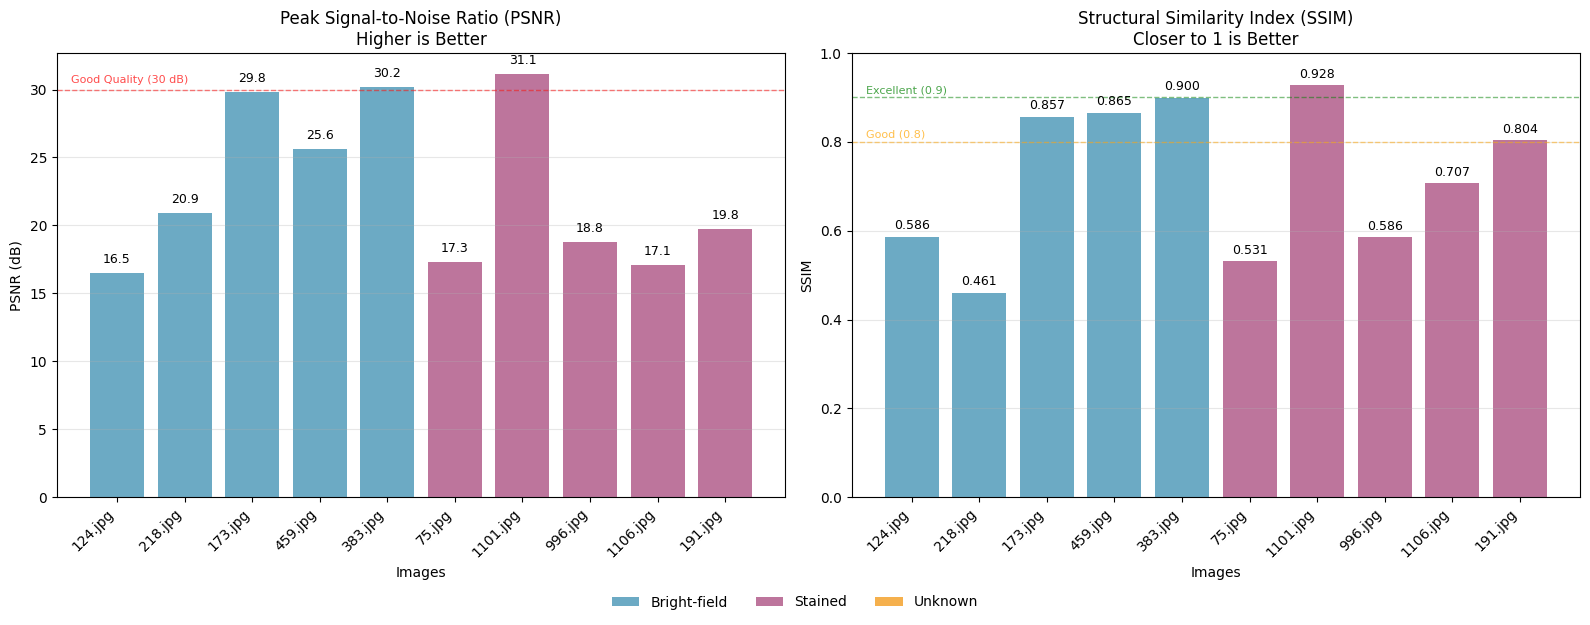

📊 Metrics visualization completed for 10 images

📈 Summary Statistics:
PSNR: Mean=22.71±5.59 dB, Range=[16.50, 31.13]
SSIM: Mean=0.722±0.162, Range=[0.461, 0.928]


In [6]:
# Visualize PSNR and SSIM metrics

if not results:
    print("⚠️ No processing results found, please run the image enhancement cell above first")
else:
    # Extract metrics data
    labels = []
    psnr_values = []
    ssim_values = []
    colors = []
    
    for orig, enhanced, label, image_type in results:
        psnr, ssim = calculate_psnr_ssim(orig, enhanced)
        labels.append(f"{os.path.basename(label)}")
        psnr_values.append(psnr)
        ssim_values.append(ssim)
        
        # Color coding by image type
        if image_type == "Bright-field":
            colors.append('#2E86AB')  # Blue for bright-field
        elif image_type == "Stained":
            colors.append('#A23B72')  # Purple for stained
        else:
            colors.append('#F18F01')  # Orange for unknown
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # PSNR chart
    bars1 = ax1.bar(range(len(labels)), psnr_values, color=colors, alpha=0.7)
    ax1.set_xlabel('Images')
    ax1.set_ylabel('PSNR (dB)')
    ax1.set_title('Peak Signal-to-Noise Ratio (PSNR)\nHigher is Better')
    ax1.set_xticks(range(len(labels)))
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add PSNR value labels on bars
    for i, (bar, value) in enumerate(zip(bars1, psnr_values)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}', ha='center', va='bottom', fontsize=9)
    
    # Add reference lines for PSNR
    ax1.axhline(y=30, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax1.text(0.02, 30.5, 'Good Quality (30 dB)', transform=ax1.get_yaxis_transform(),
             fontsize=8, color='red', alpha=0.7)
    
    # SSIM chart
    bars2 = ax2.bar(range(len(labels)), ssim_values, color=colors, alpha=0.7)
    ax2.set_xlabel('Images')
    ax2.set_ylabel('SSIM')
    ax2.set_title('Structural Similarity Index (SSIM)\nCloser to 1 is Better')
    ax2.set_xticks(range(len(labels)))
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.set_ylim([0, 1])
    ax2.grid(axis='y', alpha=0.3)
    
    # Add SSIM value labels on bars
    for i, (bar, value) in enumerate(zip(bars2, ssim_values)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Add reference lines for SSIM
    ax2.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, linewidth=1)
    ax2.axhline(y=0.8, color='orange', linestyle='--', alpha=0.5, linewidth=1)
    ax2.text(0.02, 0.91, 'Excellent (0.9)', transform=ax2.get_yaxis_transform(),
             fontsize=8, color='green', alpha=0.7)
    ax2.text(0.02, 0.81, 'Good (0.8)', transform=ax2.get_yaxis_transform(),
             fontsize=8, color='orange', alpha=0.7)
    
    plt.tight_layout()
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#2E86AB', alpha=0.7, label='Bright-field'),
                      Patch(facecolor='#A23B72', alpha=0.7, label='Stained'),
                      Patch(facecolor='#F18F01', alpha=0.7, label='Unknown')]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), 
               ncol=3, frameon=False)
    
    plt.show()
    
    print(f"📊 Metrics visualization completed for {len(results)} images")
    
    # Summary statistics
    print(f"\n📈 Summary Statistics:")
    print(f"PSNR: Mean={np.mean(psnr_values):.2f}±{np.std(psnr_values):.2f} dB, Range=[{min(psnr_values):.2f}, {max(psnr_values):.2f}]")
    print(f"SSIM: Mean={np.mean(ssim_values):.3f}±{np.std(ssim_values):.3f}, Range=[{min(ssim_values):.3f}, {max(ssim_values):.3f}]")